# Baseball Savant Pitch Selection Algorithm - Modeling

Name(s): Connor Vucovich, Doruk Ozar, and Taylor LaMantia

Class: CSCI 349 - Intro to Data Mining  

Section: 11am - 1

Semester: Spring 2024

Instructors: Brian King, Joshua Stough

This notebook is about exploring the development of predictive models. Two different modeling techniques are used to create a classification model for the baseball data. The model classifies the outcome of a pitch into 4 classes:
* Strike
* Ball
* Hit
* Field-out
based on predictor variables such as pitch type, pitcher-handedness, and pitch speed. The model types used are neural networks and decision tree. Both of the models use cross validation and grid search to enhance parameters and model training.

# Data Preparation
Prepare data 

Import necessary packages

In [166]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

import tensorflow as tf
from tensorflow import keras
from keras import Input, Model
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
from scikeras.wrappers import KerasClassifier

Read in baseball dataframe

In [59]:
# Combine parts of a file path for portability across operating systems
path = os.path.join('..', 'data', 'savant_data__2_.csv')
# Read a CSV file into a DataFrame, using the specified path
df_pitches = pd.read_csv(path)
# Set the index of the DataFrame to the 'player_name' column to allow for easier data access by player name
df_pitches.set_index('player_name', inplace=True)

Check that data is read in properly

In [60]:
df_pitches.info() # display the data types of each column

<class 'pandas.core.frame.DataFrame'>
Index: 11925 entries, Bello, Brayan to Berríos, José
Data columns (total 91 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   pitch_type                       11925 non-null  object 
 1   game_date                        11925 non-null  object 
 2   release_speed                    11925 non-null  float64
 3   release_pos_x                    11925 non-null  float64
 4   release_pos_z                    11925 non-null  float64
 5   batter                           11925 non-null  int64  
 6   pitcher                          11925 non-null  int64  
 7   events                           3015 non-null   object 
 8   description                      11925 non-null  object 
 9   spin_dir                         0 non-null      float64
 10  spin_rate_deprecated             0 non-null      float64
 11  break_angle_deprecated           0 non-null      float64
 12  bre

In [61]:
df_pitches.head(10) # display the first 10 rows of the DataFrame

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,spin_dir,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
player_name,,,,,,,,,,,,,,,,,,,,,
"Bello, Brayan",SL,2024-04-14,86.8,-1.79,5.07,543305,678394,single,hit_into_play,NaN,...,3,2,3,2,3,Standard,Standard,50.0,-0.074,0.793
"Bello, Brayan",CH,2024-04-14,83.3,-1.87,5.05,543305,678394,NaN,called_strike,NaN,...,3,2,3,2,3,Standard,Standard,246.0,0.000,-0.098
"Bello, Brayan",SI,2024-04-14,96.0,-1.81,4.96,543305,678394,NaN,swinging_strike,NaN,...,3,2,3,2,3,Standard,Standard,247.0,0.000,-0.091
"Bello, Brayan",CH,2024-04-14,84.8,-1.99,5.08,543305,678394,NaN,ball,NaN,...,3,2,3,2,3,Standard,Standard,256.0,0.000,0.056
"Bello, Brayan",SL,2024-04-14,85.5,-1.83,5.13,543305,678394,NaN,ball,NaN,...,3,2,3,2,3,Standard,Standard,27.0,-0.027,0.044
"Bello, Brayan",SI,2024-04-14,95.8,-1.69,5.02,621493,678394,single,hit_into_play,NaN,...,3,2,3,2,3,Standard,Standard,243.0,-0.041,0.287
"Bello, Brayan",SL,2024-04-14,86.8,-1.55,5.18,621493,678394,NaN,foul,NaN,...,3,2,3,2,3,Standard,Standard,56.0,0.000,0.000
"Bello, Brayan",CH,2024-04-14,85.6,-1.77,4.96,621493,678394,NaN,foul,NaN,...,3,2,3,2,3,Standard,Standard,251.0,0.000,0.000
"Berríos, José",SI,2024-04-14,93.7,-1.88,5.62,607732,621244,field_out,hit_into_play,NaN,...,4,0,4,0,4,Standard,Standard,223.0,0.004,-0.065


Replace occurences of 'hit_into_play' in the 'description' column with NaN. Fill missing values in the 'description' column with corresponding values from the 'events' column. Drop the 'events' column from the DataFrame.

In [62]:
# Create a copy of the df_pitches DataFrame to clean and manipulate the data without altering the original data
df_pitches_cleaned = df_pitches
# Replace occurrences of 'hit_into_play' in the 'description' column with NaN (not a number) values
df_pitches_cleaned['description'].replace('hit_into_play', np.nan, inplace=True)
# Fill any NaN values in the 'description' column with corresponding values from the 'events' column
df_pitches_cleaned['description'] = df_pitches_cleaned['description'].fillna(df_pitches_cleaned['events'])
# Drop the 'events' column from the DataFrame as it is no longer needed after merging its data into 'description'
df_pitches_cleaned.drop('events', axis=1, inplace=True)
# Display the first 10 rows of the cleaned DataFrame to verify changes and see the cleaned data
df_pitches_cleaned.head(10)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,description,spin_dir,spin_rate_deprecated,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
player_name,,,,,,,,,,,,,,,,,,,,,
"Bello, Brayan",SL,2024-04-14,86.8,-1.79,5.07,543305,678394,single,NaN,NaN,...,3,2,3,2,3,Standard,Standard,50.0,-0.074,0.793
"Bello, Brayan",CH,2024-04-14,83.3,-1.87,5.05,543305,678394,called_strike,NaN,NaN,...,3,2,3,2,3,Standard,Standard,246.0,0.000,-0.098
"Bello, Brayan",SI,2024-04-14,96.0,-1.81,4.96,543305,678394,swinging_strike,NaN,NaN,...,3,2,3,2,3,Standard,Standard,247.0,0.000,-0.091
"Bello, Brayan",CH,2024-04-14,84.8,-1.99,5.08,543305,678394,ball,NaN,NaN,...,3,2,3,2,3,Standard,Standard,256.0,0.000,0.056
"Bello, Brayan",SL,2024-04-14,85.5,-1.83,5.13,543305,678394,ball,NaN,NaN,...,3,2,3,2,3,Standard,Standard,27.0,-0.027,0.044
"Bello, Brayan",SI,2024-04-14,95.8,-1.69,5.02,621493,678394,single,NaN,NaN,...,3,2,3,2,3,Standard,Standard,243.0,-0.041,0.287
"Bello, Brayan",SL,2024-04-14,86.8,-1.55,5.18,621493,678394,foul,NaN,NaN,...,3,2,3,2,3,Standard,Standard,56.0,0.000,0.000
"Bello, Brayan",CH,2024-04-14,85.6,-1.77,4.96,621493,678394,foul,NaN,NaN,...,3,2,3,2,3,Standard,Standard,251.0,0.000,0.000
"Berríos, José",SI,2024-04-14,93.7,-1.88,5.62,607732,621244,field_out,NaN,NaN,...,4,0,4,0,4,Standard,Standard,223.0,0.004,-0.065


Rename column names to more descriptive and select specific columns to make df more compact.


In [63]:
# Create a new DataFrame 'df_pitches_compact' by selecting specific columns from 'df_pitches_cleaned'
df_pitches_compact = df_pitches_cleaned[['pitch_type', 'release_speed', 'effective_speed', 'spin_axis', 'release_spin_rate', 'release_extension', 'p_throws', 'pfx_x', 'pfx_z', 'description']]
# Rename the 'release_spin_rate' column to 'spin_rate' for clarity and simplicity
df_pitches_compact = df_pitches_compact.rename(columns={'release_spin_rate': 'spin_rate'})
# Rename the 'p_throws' column to 'pitcher_handedness' to more clearly describe the data it represents
df_pitches_compact = df_pitches_compact.rename(columns={'p_throws': 'pitcher_handedness'})
# Rename the 'pfx_x' column to 'horizontal_movement (ft)' to clarify that it represents the horizontal movement of the pitch in feet
df_pitches_compact = df_pitches_compact.rename(columns={'pfx_x': 'horizontal_movement (ft)'})
# Rename the 'pfx_z' column to 'vertical_movement (ft)' to clarify that it represents the vertical movement of the pitch in feet
df_pitches_compact = df_pitches_compact.rename(columns={'pfx_z': 'vertical_movement (ft)'})
# Display the first few rows of the updated DataFrame to check the new structure and the changes made
df_pitches_compact.head(10)

,pitch_type,release_speed,effective_speed,spin_axis,spin_rate,release_extension,pitcher_handedness,horizontal_movement (ft),vertical_movement (ft),description
player_name,,,,,,,,,,
"Bello, Brayan",SL,86.8,87.9,50.0,2437.0,6.4,R,0.33,0.20,single
"Bello, Brayan",CH,83.3,84.7,246.0,1737.0,6.8,R,-1.32,0.36,called_strike
"Bello, Brayan",SI,96.0,96.8,247.0,1992.0,6.7,R,-1.43,-0.11,swinging_strike
"Bello, Brayan",CH,84.8,85.6,256.0,1650.0,6.7,R,-1.34,0.29,ball
"Bello, Brayan",SL,85.5,86.4,27.0,2366.0,6.8,R,0.38,0.29,ball
"Bello, Brayan",SI,95.8,97.0,243.0,2023.0,6.7,R,-1.41,0.17,single
"Bello, Brayan",SL,86.8,87.3,56.0,2298.0,6.2,R,0.51,0.08,foul
"Bello, Brayan",CH,85.6,86.4,251.0,1533.0,6.5,R,-1.40,0.00,foul
"Berríos, José",SI,93.7,93.9,223.0,1855.0,6.6,R,-1.37,0.80,field_out


Convert pitch_type, pitcher_handedness, and description to categorical. Downcast all floats.

In [64]:
# convert necessary columns to categorical
df_pitches_compact['pitch_type'] = pd.Categorical(df_pitches_compact['pitch_type'])
df_pitches_compact['pitcher_handedness'] = pd.Categorical(df_pitches_compact['pitcher_handedness'])
df_pitches_compact['description'] = pd.Categorical(df_pitches_compact['description'])

# Convert all numeric variables to simplest numeric types
df_float_downcast = df_pitches_compact.select_dtypes('float').columns
df_pitches_compact[df_float_downcast]=df_pitches_compact[df_float_downcast].apply(pd.to_numeric, downcast='float')

# check types and sizes of columns after adjustments
df_pitches_compact.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11925 entries, Bello, Brayan to Berríos, José
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   pitch_type                11925 non-null  category
 1   release_speed             11925 non-null  float32 
 2   effective_speed           11925 non-null  float32 
 3   spin_axis                 11606 non-null  float32 
 4   spin_rate                 11606 non-null  float32 
 5   release_extension         11916 non-null  float32 
 6   pitcher_handedness        11925 non-null  category
 7   horizontal_movement (ft)  11925 non-null  float32 
 8   vertical_movement (ft)    11925 non-null  float32 
 9   description               11925 non-null  category
dtypes: category(3), float32(7)
memory usage: 455.7+ KB


Drop null values

In [65]:
df_pitches_compact.dropna(inplace=True) # drop any rows with missing values from the DataFrame
df_pitches_description = df_pitches_compact
df_pitches_compact.isna().sum() # verify that there are no longer any missing values in the DataFrame

pitch_type                  0
release_speed               0
effective_speed             0
spin_axis                   0
spin_rate                   0
release_extension           0
pitcher_handedness          0
horizontal_movement (ft)    0
vertical_movement (ft)      0
description                 0
dtype: int64

Group together target 24 classes into 4 main target classes - strike, ball, field-out, hit.

Balls: ball, blocked_ball, hit_by_pitch, pitchout

Strikes: called_strike, swinging_strike, foul, foul_tip, missed_bunt, swinging_strike_blocked, foul_bunt 

Hits: single, double, triple, home_run

Field Outs: sac_bunt, fielders_choice_out, fielders_choice, sac_fly, field_error, force_out, field_out

In [66]:
# Group hits
if 'hit' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('hit')
# Group field_out
if 'field_out' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('field_out')
# Group strike
if 'strike' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('strike')
# Group ball
if 'ball' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('ball')
for index, row in df_pitches_description.iterrows():
    if row['description'] == 'ball' or row['description'] == 'blocked_ball' or row['description'] == 'hit_by_pitch' or row['description'] == 'pitchout':
        df_pitches_description.at[index, 'description'] = 'ball'
    elif row['description'] == 'called_strike' or row['description'] == 'swinging_strike' or row['description'] == 'foul' or row['description'] == 'foul_tip' or row['description'] == 'missed_bunt' or row['description'] == 'swinging_strike_blocked' or row['description'] == 'foul_bunt':
        df_pitches_description.at[index, 'description'] = 'strike'
    elif row['description'] == 'single' or row['description'] == 'double' or row['description'] == 'triple' or row['description'] == 'home_run':
        df_pitches_description.at[index, 'description'] = 'hit'
    else:
        df_pitches_description.at[index, 'description'] = 'field_out'
df_pitches_description['description'].value_counts()

description
strike                       6302
ball                         4362
field_out                     619
hit                           316
called_strike                   0
home_run                        0
triple                          0
swinging_strike_blocked         0
swinging_strike                 0
single                          0
sac_fly                         0
sac_bunt                        0
pitchout                        0
missed_bunt                     0
hit_by_pitch                    0
double                          0
blocked_ball                    0
foul_tip                        0
foul_bunt                       0
foul                            0
force_out                       0
fielders_choice_out             0
fielders_choice                 0
field_error                     0
double_play                     0
grounded_into_double_play       0
Name: count, dtype: int64

In [67]:
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['blocked_ball'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['called_strike'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['double'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['double_play'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['field_error'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['fielders_choice'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['fielders_choice_out'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['force_out'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['foul'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['foul_bunt'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['foul_tip'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['grounded_into_double_play'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['hit_by_pitch'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['home_run'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['missed_bunt'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['pitchout'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['sac_bunt'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['sac_fly'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['single'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['swinging_strike'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['swinging_strike_blocked'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['triple'])

In [68]:
# Change name of dataframe to be for model
df_pitches_model = df_pitches_description
df_pitches_model['description'].unique()

['ball', 'field_out', 'strike', 'hit']
Categories (4, object): ['ball', 'field_out', 'hit', 'strike']

In [69]:
df_pitches_model.columns

Index(['pitch_type', 'release_speed', 'effective_speed', 'spin_axis',
       'spin_rate', 'release_extension', 'pitcher_handedness',
       'horizontal_movement (ft)', 'vertical_movement (ft)', 'description'],
      dtype='object')

Split data into X and y frames

In [70]:
X = df_pitches_model[['pitch_type', 'release_speed', 'effective_speed',
       'spin_axis', 'spin_rate', 'release_extension', 'pitcher_handedness',
       'horizontal_movement (ft)', 'vertical_movement (ft)']]

y = df_pitches_model['description']
X.head(10)

,pitch_type,release_speed,effective_speed,spin_axis,spin_rate,release_extension,pitcher_handedness,horizontal_movement (ft),vertical_movement (ft)
player_name,,,,,,,,,
"Bello, Brayan",SL,86.800003,87.900002,50.0,2437.0,6.4,R,0.33,0.20
"Bello, Brayan",CH,83.300003,84.699997,246.0,1737.0,6.8,R,-1.32,0.36
"Bello, Brayan",SI,96.000000,96.800003,247.0,1992.0,6.7,R,-1.43,-0.11
"Bello, Brayan",CH,84.800003,85.599998,256.0,1650.0,6.7,R,-1.34,0.29
"Bello, Brayan",SL,85.500000,86.400002,27.0,2366.0,6.8,R,0.38,0.29
"Bello, Brayan",SI,95.800003,97.000000,243.0,2023.0,6.7,R,-1.41,0.17
"Bello, Brayan",SL,86.800003,87.300003,56.0,2298.0,6.2,R,0.51,0.08
"Bello, Brayan",CH,85.599998,86.400002,251.0,1533.0,6.5,R,-1.40,0.00
"Berríos, José",SI,93.699997,93.900002,223.0,1855.0,6.6,R,-1.37,0.80


In [71]:
y.head(10)

player_name
Bello, Brayan         ball
Bello, Brayan         ball
Bello, Brayan         ball
Bello, Brayan         ball
Bello, Brayan         ball
Bello, Brayan         ball
Bello, Brayan         ball
Bello, Brayan         ball
Berríos, José    field_out
Bello, Brayan         ball
Name: description, dtype: category
Categories (4, object): ['ball', 'field_out', 'hit', 'strike']

Binarize all categorical columns. In X these are pitch_type and pitcher_handedness. In y this is the entire data. The data needs to be binarized for the neural network.

In [72]:
X_binarized = pd.get_dummies(X, dtype=int)
y_binarized = pd.get_dummies(y, dtype=int)
X_binarized.sample(10)

,release_speed,effective_speed,spin_axis,spin_rate,release_extension,horizontal_movement (ft),vertical_movement (ft),pitch_type_CH,pitch_type_CU,pitch_type_EP,...,pitch_type_FF,pitch_type_FS,pitch_type_KC,pitch_type_PO,pitch_type_SI,pitch_type_SL,pitch_type_ST,pitch_type_SV,pitcher_handedness_L,pitcher_handedness_R
player_name,,,,,,,,,,,,,,,,,,,,,
"Devenski, Chris",92.699997,92.599998,210.0,2347.0,6.4,-0.78,1.48,0,0,0,...,1,0,0,0,0,0,0,0,0,1
"Bello, Brayan",87.699997,87.900002,29.0,2351.0,6.4,0.85,-0.08,0,0,0,...,0,0,0,0,0,1,0,0,0,1
"Martin, Chris",90.800003,90.599998,192.0,2227.0,6.4,0.10,0.87,0,0,0,...,0,0,0,0,0,0,0,0,0,1
"Kimbrel, Craig",93.199997,94.500000,224.0,2417.0,7.3,-0.77,1.22,0,0,0,...,1,0,0,0,0,0,0,0,0,1
"Ramírez, Yohan",81.300003,81.800003,62.0,2629.0,7.1,1.61,0.13,0,0,0,...,0,0,0,0,0,0,1,0,0,1
"Jansen, Kenley",92.900002,94.599998,175.0,2519.0,7.0,0.61,1.39,0,0,0,...,0,0,0,0,0,0,0,0,0,1
"Tate, Dillon",90.199997,90.599998,230.0,1879.0,6.7,-1.37,0.29,0,0,0,...,0,0,0,0,1,0,0,0,0,1
"Webb, Jacob",91.000000,91.000000,228.0,2272.0,6.6,-0.75,1.35,0,0,0,...,1,0,0,0,0,0,0,0,0,1
"Littell, Zack",84.000000,83.900002,252.0,1002.0,5.9,-0.09,0.05,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [73]:
y_binarized.sample(10)

,ball,field_out,hit,strike
player_name,,,,
"Cortes, Nestor",0,0,0,1
"Francis, Bowden",0,0,1,0
"White, Mitch",0,0,0,1
"Alexander, Tyler",1,0,0,0
"Heasley, Jonathan",0,0,0,1
"Kikuchi, Yusei",0,0,0,1
"Santana, Dennis",0,0,0,1
"Burdi, Nick",1,0,0,0
"Weissert, Greg",0,0,0,1


Split data into training and test sets

In [178]:
train_X, test_X, train_y, test_y = train_test_split(X_binarized, y_binarized, test_size=0.2, random_state=42)
test_y

,ball,field_out,hit,strike
player_name,,,,
"Rodriguez, Grayson",1,0,0,0
"Wells, Tyler",0,0,0,1
"Rodón, Carlos",1,0,0,0
"Cleavinger, Garrett",1,0,0,0
"Jansen, Kenley",0,0,0,1
...,...,...,...,...
"Campbell, Isaiah",0,0,0,1
"Pivetta, Nick",0,0,0,1
"Littell, Zack",1,0,0,0


Standardize data

In [75]:
std = StandardScaler()
train_X_standardized = pd.DataFrame(std.fit_transform(train_X), columns=train_X.columns, index=train_X.index)
test_X_standardized = pd.DataFrame(std.transform(test_X), columns=test_X.columns, index=test_X.index)


---
# Neural Networks Model
---

In [138]:
# Define a function that creates a Keras model
def create_keras_model(num_hidden, activation='relu', optimizer='adam', loss='categorical_crossentropy', metrics='accuracy'):

    inputs = Input(shape=train_X_standardized.shape[1]) # input layer
    
    # our hidden layer is parameterized
    layer = Dense(num_hidden, activation=activation)(inputs)
    
    outputs = Dense(test_y.shape[1],activation="softmax")(layer) # output layer
    
    model = Model(inputs=inputs, outputs=outputs, name="model_2") # build the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics) # compile the model

    return model

In [139]:
# Create a KerasClassifier from the create_keras_model function
keras_model = KerasClassifier(model=create_keras_model, verbose=0, epochs=10, batch_size=32, model__num_hidden=20)

In [140]:
history = keras_model.fit(train_X_standardized, train_y, verbose=1,validation_data=(test_X_standardized, test_y))

Epoch 1/10
290/290 [==============================] - 0s 593us/step - loss: 1.0757 - accuracy: 0.5007 - val_loss: 0.9122 - val_accuracy: 0.5539
Epoch 2/10
290/290 [==============================] - 0s 443us/step - loss: 0.8699 - accuracy: 0.5841 - val_loss: 0.8536 - val_accuracy: 0.5978
Epoch 3/10
290/290 [==============================] - 0s 417us/step - loss: 0.8292 - accuracy: 0.6075 - val_loss: 0.8269 - val_accuracy: 0.6142
Epoch 4/10
290/290 [==============================] - 0s 429us/step - loss: 0.8055 - accuracy: 0.6238 - val_loss: 0.8065 - val_accuracy: 0.6379
Epoch 5/10
290/290 [==============================] - 0s 412us/step - loss: 0.7895 - accuracy: 0.6390 - val_loss: 0.7947 - val_accuracy: 0.6418
Epoch 6/10
290/290 [==============================] - 0s 420us/step - loss: 0.7743 - accuracy: 0.6472 - val_loss: 0.7852 - val_accuracy: 0.6547
Epoch 7/10
290/290 [==============================] - 0s 420us/step - loss: 0.7621 - accuracy: 0.6598 - val_loss: 0.7742 - val_accuracy:

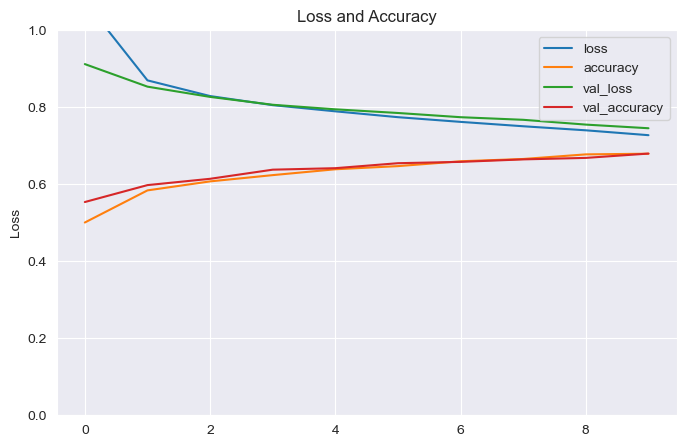

In [141]:
pd.DataFrame(history.history_).plot( figsize=(8, 5),grid=True, ylim=(0,1),ylabel="Loss")
plt.title('Loss and Accuracy')
plt.show()
# history.history_['loss']


In [142]:
%%time
scores = cross_val_score(keras_model, train_X_standardized, train_y, cv=5, scoring='accuracy') # perform a cross validation
print('Mean Absolute Percentage Error scores of each fold: ', [f'{100*acc:.3f}' for acc in scores]) # print the scores of each fold
print(f'Mean Absolute Percentage Error across 5 folds: {100*scores.mean():.3f} (+/- {100*scores.std() * 2:.3f})') # print the average score and the standard deviation

Mean Absolute Percentage Error scores of each fold:  ['65.032', '64.440', '64.278', '65.841', '68.679']
Mean Absolute Percentage Error across 5 folds: 65.654 (+/- 3.218)
CPU times: user 5.44 s, sys: 3.3 s, total: 8.74 s
Wall time: 4.25 s


In [143]:
%%time
keras_model = KerasClassifier(model=create_keras_model,
                      verbose=0, random_state=42) 

param_grid = {
    "model__optimizer" : ['adam', 'sgd'],
    "model__num_hidden": [100, 120],
    "epochs" : [175, 200],
    "batch_size" : [8, 16],
    "model__loss" : ['categorical_crossentropy', 'sparse_categorical_crossentropy'],
} # define the parameter grid

# param_grid = {
#     "model__num_hidden": [100, 120],
#     "epochs" : [175, 200],
# } # define the parameter grid

grid = GridSearchCV(keras_model, param_grid, return_train_score=True, cv=5, scoring='accuracy', n_jobs=-1, verbose=2) # define the GridSearchCV
grid_result = grid.fit(train_X_standardized, train_y) # fit the model using GridSearchCV

Fitting 5 folds for each of 32 candidates, totalling 160 fits


2024-04-26 12:29:18.955153: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:29:18.957364: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:29:18.957646: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:29:18.959138: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:29:18.959911: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:29:18.962634: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:29:18.963117: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:29:18.963870: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:29:18.964091: W te

[CV] END .criterion=gini, max_depth=20, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, min_samples_split=5; total time=   0.1s
[CV] END criterion=entropy, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END ..criterion=gini, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_split=10; total time=   0.0s
[CV] END ..criterion=gini, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END ..criterion=gini, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END .criterion=gini, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END .criterion=gini, max_depth=40, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END criterion=

/Users/dorukozar/anaconda3/envs/csci349/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-04-26 12:32:34.985778: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[CV] END .criterion=gini, max_depth=20, min_samples_split=10; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, min_samples_split=5; total time=   0.1s
[CV] END .criterion=gini, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_split=10; total time=   0.0s
[CV] END ..criterion=gini, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_split=10; total time=   0.0s
[CV] END ..criterion=gini, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_split=10; total time=   0.1s
[CV] END criterion=log_loss, max_depth=40, min_samples_split=10; total time=   0.0s
[CV] END batc

2024-04-26 12:32:43.825415: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:32:44.491931: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[CV] END ..criterion=gini, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, min_samples_split=10; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, min_samples_split=10; total time=   0.0s
[CV] END .criterion=gini, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END .criterion=gini, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END .criterion=gini, max_depth=40, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END criterion=log_loss, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END batch_size=8, epochs=175, model__loss=categorical_crossentropy, model__num_hidden=100, model__optimizer=sgd; total time= 3.4min
[CV] END ..criterion=gini, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END ..criterion=gini, max_depth=40, min_

2024-04-26 12:32:46.628154: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:32:46.988733: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:32:47.556789: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[CV] END .criterion=gini, max_depth=20, min_samples_split=10; total time=   0.1s
[CV] END criterion=entropy, max_depth=20, min_samples_split=10; total time=   0.0s
[CV] END ..criterion=gini, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END .criterion=gini, max_depth=40, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END ..criterion=gini, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END .criterion=gini, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_split=10; total time=   0.0s
[CV] END criterion=log_loss, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END batch_size=8, epochs=175, model__loss=categorical_crossentropy, model__num_hidden=100, m

2024-04-26 12:32:53.500691: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:32:53.913777: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[CV] END ..criterion=gini, max_depth=20, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END .criterion=gini, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=5; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, min_samples_split=10; total time=   0.0s
[CV] END ..criterion=gini, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END ..criterion=gini, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END ..criterion=gini, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END criterion=log_loss, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END batch_size=8, epochs=175, model__loss=categorical_crossentropy, model__num_hidden=100, mode

2024-04-26 12:32:56.566776: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[CV] END ..criterion=gini, max_depth=20, min_samples_split=5; total time=   0.0s
[CV] END .criterion=gini, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=5; total time=   0.1s
[CV] END criterion=entropy, max_depth=40, min_samples_split=5; total time=   0.1s
[CV] END ..criterion=gini, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=10; total time=   0.1s
[CV] END .criterion=gini, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_split=10; total time=   0.0s
[CV] END criterion=log_loss, max_depth=40, min_samples_split=5; total time=   0.1s
[CV] END batch_size=8, epochs=175, model__loss=categorical_crossentropy, model__num_hidden=120, model__optimizer=adam; total time= 3.6min
[CV] END .criterion=gini, max_depth=30, min

2024-04-26 12:32:57.555003: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:32:58.528794: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:32:58.983493: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:32:59.442099: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[CV] END ..criterion=gini, max_depth=20, min_samples_split=5; total time=   0.0s
[CV] END .criterion=gini, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, min_samples_split=10; total time=   0.0s
[CV] END ..criterion=gini, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END ..criterion=gini, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END ..criterion=gini, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END .criterion=gini, max_depth=40, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END ..criterion=gini, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_split=10; total time=   0.0s
[CV] END criterion=l

2024-04-26 12:33:01.470647: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-26 12:33:01.760424: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[CV] END ..criterion=gini, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, min_samples_split=10; total time=   0.1s
[CV] END ..criterion=gini, max_depth=30, min_samples_split=5; total time=   0.0s
[CV] END ..criterion=gini, max_depth=40, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END .criterion=gini, max_depth=40, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_split=5; total time=   0.1s
[CV] END criterion=log_loss, max_depth=30, min_samples_split=10; total time=   0.0s
[CV] END batch_size=8, epochs=175, model__loss=categorical_crossentropy, model__num_hidden=120, model__optimizer=adam; total time= 4.4min


2024-04-26 12:33:44.834045: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/dorukozar/anaconda3/envs/csci349/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dorukozar/anaconda3/envs/csci349/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dorukozar/anaconda3/envs/csci349/lib/python3.10/site-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X

[CV] END batch_size=8, epochs=175, model__loss=sparse_categorical_crossentropy, model__num_hidden=100, model__optimizer=adam; total time=   0.4s
[CV] END batch_size=8, epochs=175, model__loss=sparse_categorical_crossentropy, model__num_hidden=100, model__optimizer=adam; total time=   0.2s
[CV] END batch_size=8, epochs=175, model__loss=sparse_categorical_crossentropy, model__num_hidden=100, model__optimizer=adam; total time=   0.2s
[CV] END batch_size=8, epochs=175, model__loss=sparse_categorical_crossentropy, model__num_hidden=100, model__optimizer=adam; total time=   0.1s
[CV] END batch_size=8, epochs=175, model__loss=sparse_categorical_crossentropy, model__num_hidden=100, model__optimizer=sgd; total time=   0.2s
[CV] END batch_size=8, epochs=175, model__loss=sparse_categorical_crossentropy, model__num_hidden=100, model__optimizer=sgd; total time=   0.3s
[CV] END batch_size=8, epochs=175, model__loss=sparse_categorical_crossentropy, model__num_hidden=120, model__optimizer=adam; total 

In [144]:
best_score = grid_result.best_score_ # Save the best score.
best_params = grid_result.best_params_ # Save the best parameters.
best_NN_classifier = grid_result.best_estimator_ # Save the best model.
print(f"Best Parameters: {best_params}")
print(f"Best Score: {round((best_score * 100), 2)}%")

Best Parameters: {'batch_size': 8, 'epochs': 200, 'model__loss': 'categorical_crossentropy', 'model__num_hidden': 100, 'model__optimizer': 'adam'}
Best Score: 86.4%


In [145]:
history = best_NN_classifier.fit(train_X_standardized, train_y, verbose=1,validation_data=(test_X_standardized, test_y))

Epoch 1/200
1160/1160 [==============================] - 1s 512us/step - loss: 0.8281 - accuracy: 0.5998 - val_loss: 0.7741 - val_accuracy: 0.6375
Epoch 2/200
1160/1160 [==============================] - 1s 476us/step - loss: 0.7297 - accuracy: 0.6632 - val_loss: 0.7060 - val_accuracy: 0.6935
Epoch 3/200
1160/1160 [==============================] - 1s 468us/step - loss: 0.6706 - accuracy: 0.7015 - val_loss: 0.6675 - val_accuracy: 0.6905
Epoch 4/200
1160/1160 [==============================] - 1s 472us/step - loss: 0.6258 - accuracy: 0.7260 - val_loss: 0.6356 - val_accuracy: 0.7177
Epoch 5/200
1160/1160 [==============================] - 1s 468us/step - loss: 0.5908 - accuracy: 0.7431 - val_loss: 0.6088 - val_accuracy: 0.7371
Epoch 6/200
1160/1160 [==============================] - 1s 465us/step - loss: 0.5652 - accuracy: 0.7539 - val_loss: 0.5955 - val_accuracy: 0.7228
Epoch 7/200
1160/1160 [==============================] - 1s 468us/step - loss: 0.5431 - accuracy: 0.7641 - val_loss: 0

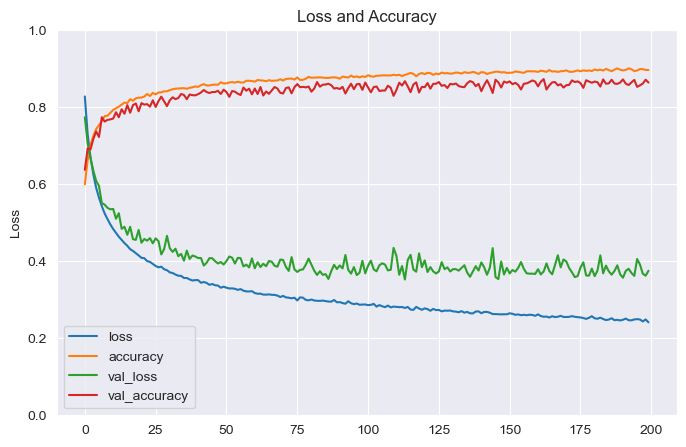

In [146]:
pd.DataFrame(history.history_).plot( figsize=(8, 5),grid=True, ylim=(0,1),ylabel="Loss")
plt.title('Loss and Accuracy')
plt.show()

In [147]:
train_pred_y = best_NN_classifier.predict(train_X_standardized) # predict the training data
print("TRAINING DATA")
print(classification_report(train_y, train_pred_y))

TRAINING DATA
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      3486
           1       0.90      0.94      0.92       492
           2       0.75      0.80      0.78       253
           3       0.90      0.93      0.92      5048

   micro avg       0.90      0.90      0.90      9279
   macro avg       0.87      0.88      0.87      9279
weighted avg       0.90      0.90      0.90      9279
 samples avg       0.90      0.90      0.90      9279


In [148]:
test_pred_y = best_NN_classifier.predict(test_X_standardized) # predict the training data
print("TESTING DATA")
print(classification_report(test_y, test_pred_y))

TESTING DATA
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       876
           1       0.87      0.87      0.87       127
           2       0.62      0.62      0.62        63
           3       0.87      0.90      0.88      1254

   micro avg       0.86      0.86      0.86      2320
   macro avg       0.81      0.80      0.81      2320
weighted avg       0.86      0.86      0.86      2320
 samples avg       0.86      0.86      0.86      2320


In [149]:
print(f" Testing Accuracy: {round((100*best_NN_classifier.score(test_X_standardized, test_y)), 3)}%")

 Testing Accuracy: 86.422%


---
# Decision Tree Model
---

Define and initialize the Decision Tree Classifier. Fit the model to the training data.

In [20]:
dtree_clf = DecisionTreeClassifier(criterion="entropy", splitter='best', max_depth=5, min_samples_split=10, random_state=42)
dtree_clf.fit(train_X, train_y)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=10,
                       random_state=42)

Plot the decision tree

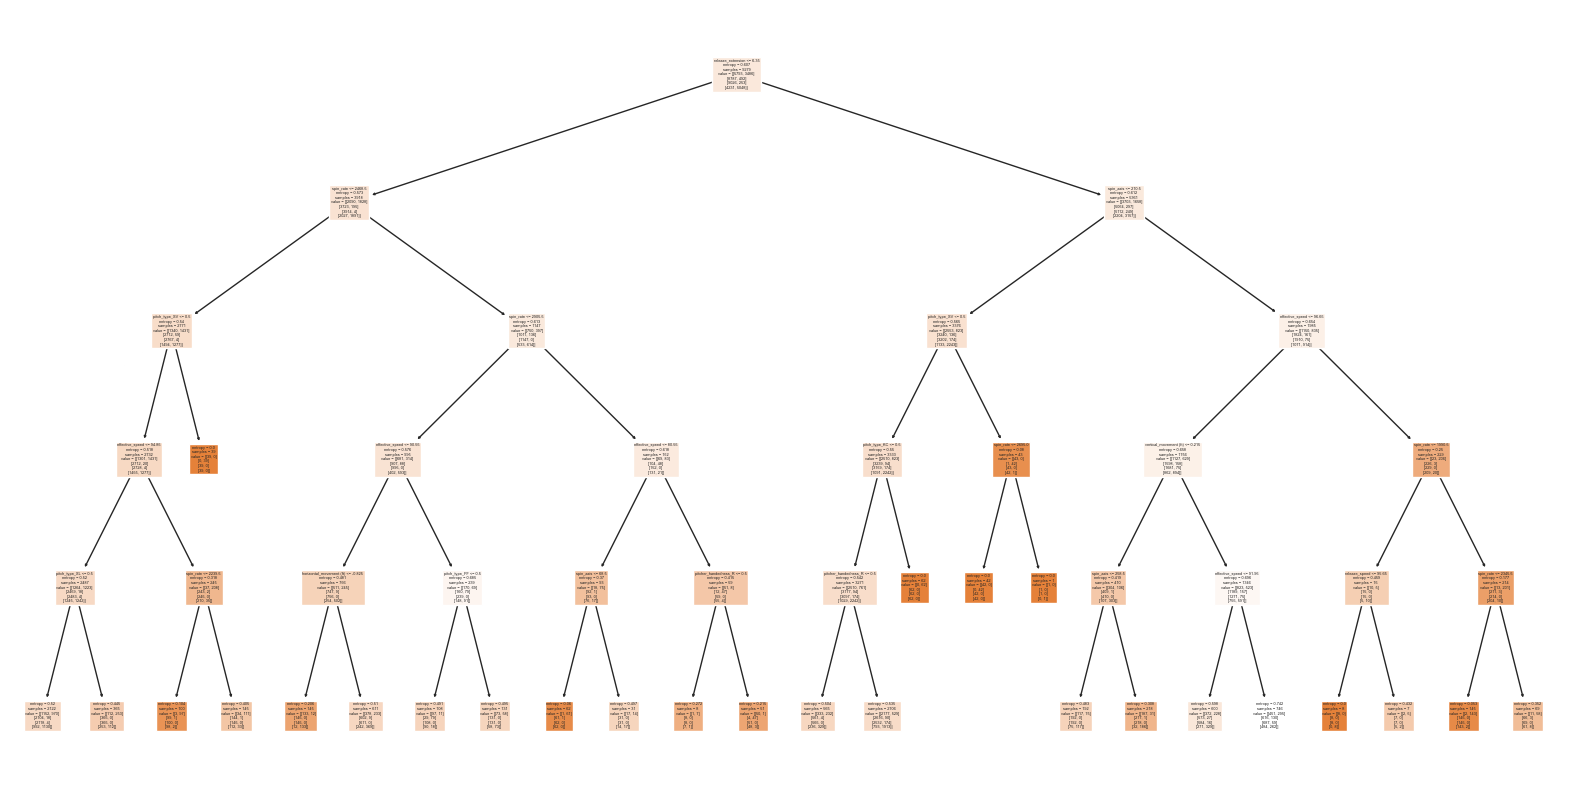

In [21]:
# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(dtree_clf, filled=True, feature_names=train_X.columns.tolist(), class_names=list(y.cat.categories))
plt.show()

perform a cross validation. As you can see, the model is not very accurate.

In [22]:
%%time
scores = cross_val_score(dtree_clf, train_X, train_y, cv=5, scoring='accuracy') # perform a cross validation
print('Mean Absolute Percentage Error scores of each fold: ', [f'{100*acc:.3f}' for acc in scores]) # print the scores of each fold
print(f'Mean Absolute Percentage Error across 5 folds: {100*scores.mean():.3f} (+/- {100*scores.std() * 2:.3f})') # print the average score and the standard deviation

Mean Absolute Percentage Error scores of each fold:  ['55.280', '58.890', '57.974', '53.287', '60.054']
Mean Absolute Percentage Error across 5 folds: 57.097 (+/- 4.943)
CPU times: user 83.4 ms, sys: 2.16 ms, total: 85.5 ms
Wall time: 85.7 ms


predict the training data 

In [23]:
train_pred_y = dtree_clf.predict(train_X) # predict the training data

Print the accuracy

In [24]:
print(f"Accuracy: {round((dtree_clf.score(train_X, train_y))*100, 2)}%")

Accuracy: 60.45%


Print the classification report.

In [25]:
print("TRAINING DATA")
print(classification_report(train_y, train_pred_y))

TRAINING DATA
              precision    recall  f1-score   support

           0       0.83      0.23      0.36      3486
           1       0.86      0.42      0.57       492
           2       0.00      0.00      0.00       253
           3       0.63      0.91      0.74      5048

   micro avg       0.66      0.60      0.63      9279
   macro avg       0.58      0.39      0.42      9279
weighted avg       0.70      0.60      0.57      9279
 samples avg       0.60      0.60      0.60      9279


/Users/dorukozar/anaconda3/envs/csci349/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dorukozar/anaconda3/envs/csci349/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Perform a hyperparameter tuning using GridSearchCV to find the best parameters for the Decision Tree Classifier.

In [26]:
dtree_clf = DecisionTreeClassifier(random_state=42)

param_grid = {
    "criterion" : ['gini', 'entropy', 'log_loss'],
    "max_depth" : [30, 40],
    "min_samples_split" : [5, 10],
} # define the parameter grid
grid = GridSearchCV(dtree_clf, param_grid, return_train_score=True, cv=5, scoring='accuracy', n_jobs=-1, verbose=2) # define the GridSearchCV
grid_result = grid.fit(train_X, train_y) # fit the model using GridSearchCV

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Print the best parameters and the best score.

In [27]:
best_score = grid_result.best_score_ # Save the best score.
best_params = grid_result.best_params_ # Save the best parameters.
best_tree_classifier = grid_result.best_estimator_ # Save the best model.
print(f"Best Parameters: {best_params}")
print(f"Best Score: {round((best_score * 100), 2)}%")

Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 5}
Best Score: 79.55%


Predict the training data and print the classification report.

In [28]:
train_pred_y = best_tree_classifier.predict(train_X) # predict the training data
print("TRAINING DATA")
print(classification_report(train_y, train_pred_y))

TRAINING DATA
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3486
           1       0.98      0.94      0.96       492
           2       0.96      0.92      0.94       253
           3       0.99      0.97      0.98      5048

   micro avg       0.99      0.97      0.98      9279
   macro avg       0.98      0.95      0.97      9279
weighted avg       0.99      0.97      0.98      9279
 samples avg       0.97      0.97      0.97      9279


/Users/dorukozar/anaconda3/envs/csci349/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predict the testing data and print the classification report.

In [29]:
test_pred_y = best_tree_classifier.predict(test_X) # predict the training data
print("TESTING DATA")
print(classification_report(test_y, test_pred_y))

TESTING DATA
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       876
           1       0.81      0.72      0.77       127
           2       0.48      0.51      0.50        63
           3       0.86      0.84      0.85      1254

   micro avg       0.83      0.81      0.82      2320
   macro avg       0.74      0.72      0.73      2320
weighted avg       0.83      0.81      0.82      2320
 samples avg       0.81      0.81      0.81      2320


/Users/dorukozar/anaconda3/envs/csci349/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print(f"Testing Accuracy: {round((100*best_tree_classifier.score(test_X, test_y)), 3)}%")

Testing Accuracy: 81.078%


In [157]:
train_y_columns = train_y.columns
test_y_columns = test_y.columns
test_y_columns

CategoricalIndex(['ball', 'field_out', 'hit', 'strike'], categories=['ball', 'field_out', 'hit', 'strike'], ordered=False, dtype='category')

In [179]:
train_y['description'] = train_y[['ball', 'field_out', 'hit', 'strike']].idxmax(axis=1)
train_y['description'] = train_y['description'].astype('category')
train_y_encoded = train_y['description'].cat.codes
train_y_encoded

player_name
Irvin, Cole          0
Rodríguez, Joely     3
Wells, Tyler         3
Pepiot, Ryan         3
Civale, Aaron        0
                    ..
Burnes, Corbin       3
Maton, Phil          3
Wells, Tyler         3
Rodríguez, Yariel    0
Burnes, Corbin       3
Length: 9279, dtype: int8

In [180]:
test_y['description'] = test_y[['ball', 'field_out', 'hit', 'strike']].idxmax(axis=1)
test_y['description'] = test_y['description'].astype('category')
test_y_encoded = test_y['description'].cat.codes
test_y_encoded

player_name
Rodriguez, Grayson     0
Wells, Tyler           3
Rodón, Carlos          0
Cleavinger, Garrett    0
Jansen, Kenley         3
                      ..
Campbell, Isaiah       3
Pivetta, Nick          3
Littell, Zack          0
Crawford, Kutter       0
Weaver, Luke           3
Length: 2320, dtype: int8

In [181]:
len(np.unique(train_y_encoded))

4

In [182]:
best_tree_classifier.fit(train_X, train_y_encoded)
train_pred_y_prob = best_tree_classifier.predict_proba(train_X)
train_pred_y_prob
# print(f"Testing Accuracy: {round((100*best_tree_classifier.score(test_X, test_y)), 3)}%")

array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       ...,
       [0.        , 0.        , 0.        , 1.        ],
       [0.33333333, 0.        , 0.        , 0.66666667],
       [0.        , 0.        , 0.        , 1.        ]])

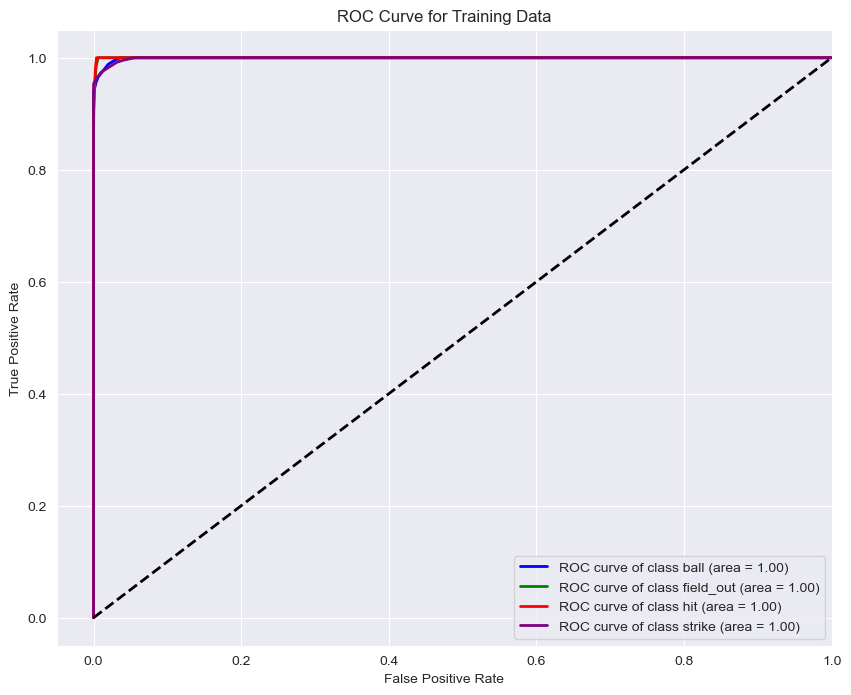

In [183]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple']  # Adjust colors based on actual number of classes

# for i in range(len(encoder.classes_)):
for i in range(len(np.unique(train_y_encoded))):
    fpr, tpr, _ = roc_curve(train_y_encoded == i, train_pred_y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(train_y_columns[i], roc_auc))
    # plt.plot(fpr, tpr, color=colors[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.legend(loc="lower right")
plt.show()

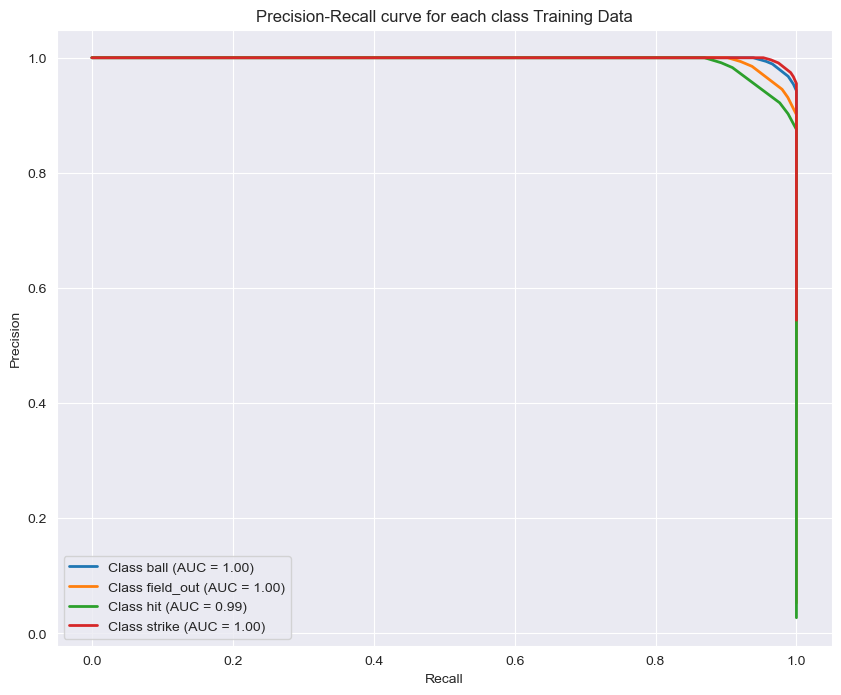

In [184]:

plt.figure(figsize=(10, 8))

for i in range(len(np.unique(train_y_encoded))):
    # Compute precision and recall for each class
    precision, recall, _ = precision_recall_curve(train_y_encoded == i, train_pred_y_prob[:, i])
    pr_auc = auc(recall, precision)

    # Plot the precision-recall curve for the class
    plt.plot(recall, precision, lw=2, label=f'Class {train_y_columns[i]} (AUC = {pr_auc:.2f})')
    # break

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class Training Data')
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [185]:
test_pred_y_prob = best_tree_classifier.predict_proba(test_X)
test_pred_y_prob

array([[1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 1.  ],
       ...,
       [0.75, 0.  , 0.  , 0.25],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ]])

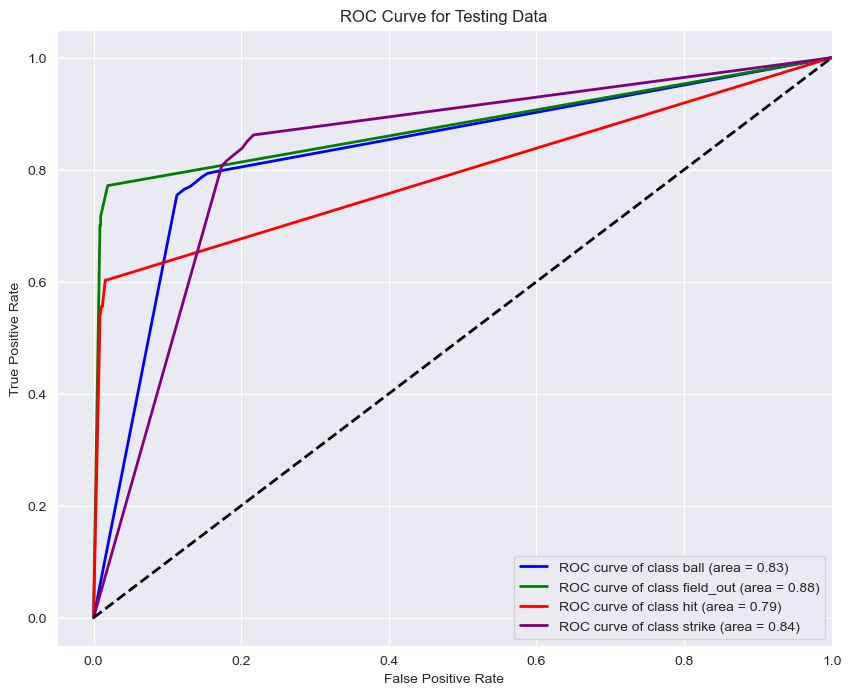

In [186]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple']  # Adjust colors based on actual number of classes

for i in range(len(np.unique(test_y_encoded))):
    fpr, tpr, _ = roc_curve(test_y_encoded == i, test_pred_y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(test_y_columns[i], roc_auc))
    # plt.fill_between(fpr, tpr, color=colors[i], alpha=0.2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Testing Data')
plt.legend(loc="lower right")
plt.show()

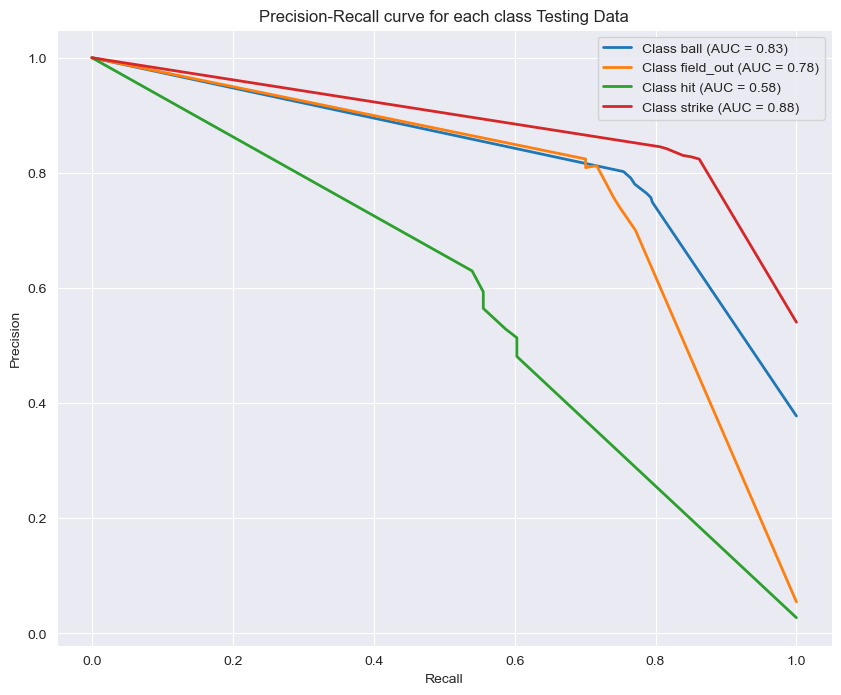

In [187]:
plt.figure(figsize=(10, 8))

for i in range(len(np.unique(test_y_encoded))):
    # Compute precision and recall for each class
    precision, recall, _ = precision_recall_curve(test_y_encoded == i, test_pred_y_prob[:, i])
    pr_auc = auc(recall, precision)

    # Plot the precision-recall curve for the class
    plt.plot(recall, precision, lw=2, label=f'Class {test_y_columns[i]} (AUC = {pr_auc:.2f})')
    # break

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class Testing Data')
plt.legend(loc="best")
plt.grid(True)
plt.show()

## Conclusion

As you can see, this model is not as good as the Neural Network model. The Decision Tree model is not as accurate and does not perform as well as the Neural Network model. The Neural Network model is the better model for this data.

In [194]:
from joblib import dump, load

keras_model = load('/Users/dorukozar/PycharmProjects/csci349_2024sp/final_project/project/best_NN_classifier.pkl')

AttributeError: Can't get attribute 'create_keras_model' on <module '__main__'>